# IOT for Pandemics

This notebook is part of [*Practical Data Science for IOT*](https://github.com/pablodecm/datalab_ml_iot) tutorial by Pablo de Castro

## What can we do? (in addition to staying at home)

Given the current COVID19 pandemic that is currently undergoing (this was initially
written the 25th of March in Spain), it is worth thinking about possible technological
solutions that could help improve or manage this crisis or future pandemics.

<br>

<div align="center">
  <img src="https://github.com/pablodecm/datalab_ml_iot/blob/master/03_iot_for_pandemics/images/data_science_diagram.png?raw=1" width="40%">
</div>


## Brainstorming Ideas

Let's think about different solutions that could help with the crisis that use IOT technologies and data science, by iterating following this structure:



### WHY

The actual problem or challenge that we are trying to solve. <br>
Described in specific terms (not in general terms).  <br>
Could be sub-problems of a larger problem.

### HOW

Which technologies could be used to address the WHY. <br>
How will these technologies interact. Estimate human and economical costs.  <br>
Sketch the system components and how they play together.

### WHAT

Name or describe the solution. <br>
Could it really address the WHY? <br>
If yes, great! **Get feedback and/or try to build a PoC!** <br>
If not, do not worry, keep iterating!

## Be bold!

**Homework**: let's think individually or in groups about technological solutions of Data Science and IOT that could help with the COVID19 crisis following the previous structure.



Send your ideas with this Google Form and we will discuss them tomorrow in class form:

https://forms.gle/tZJh8hE3vLdwyyQW8

## Extra for tomorrow

Go to  https://takeout.google.com/settings/takeout and download your own Location History data and keep it save, in the exercise tomorrow we will use our own location data. If possible, try to get the location data of someone else to study contract tracing between people.

<div align="center">
  <img src="https://github.com/pablodecm/datalab_ml_iot/blob/master/03_iot_for_pandemics/images/google_takeout.png?raw=1" width="50%">
</div>

## Example Idea


### WHY

SARS-CoV-2 virus is very contagious, due to the combined effect of a long incubation period, a large fraction of infected people only developing mild symptoms yet still being contagious and a high survivability in surfaces and air droplets.

Uncontrolled transmission in the population can cause rapid growth with an associated large mortality within risk groups and easily overwhelm the health systems. Strong confinement and social distancing  seem the only effective way to stop the rapid spread if it is already out of control.

While country-wide confinement is required in the short-term to stop the current transmission waves, it might not be sustainable long-term from a social and economical perspective (vaccine production at scale it is probably years away and treatments are likely to be of help but not a definite solution).

**Without confinement even with massive testing it is really hard to track the virus transmission chain at scale, i.e. to find out who is likely to be infected by someone that has just tested positive. Better ways to trace transmissions between the population
allow more directed testing campaign and containment by small group confinements.**






### HOW

Modern technology is likely to help with the problem of tracking the transmission chain. We need a way to register potential virus transmissions between people so it could be used to trace the graph of possible infections once someone has tested positive.

This could be done with a powerful surveillance infrastructure, which is lacking in most countries and building it at the required scale is not possible or desired. Alternatively, the solution could be build based on people knowingly carrying personal devices, either voluntarily or enforced in public space until the crisis is controlled.

Large fractions of the world population already own a internet-capable sensor-rich smartphone, and additional smartphone-like devices could be also provided at scale for those that do not.

**A transmission trace system at national or multi-national scale can be based on location (e.g. cell phone tower triangulation or A-GPS logs), close distance between peers (e.g. ultrasound or Bluetooth) or a combination of all these technologies. Data already collected by companies could also be reused. A secure and escalable data collection and analysis infrastructure could be build rapidly in the cloud and managed by a trusted parties**



### WHAT

A contact tracing system based on data collection by smartphones and other personal devices could be build in a short amount of time and could potentially address the problem of tracing the transmission chains, which in turn can be use to direct testing campaigns and enforce small group confinement, keeping most of the societal and economical activity intact.

While promising, there are also unexplored concern regarding data protection and privacy, the different capabilities of the technologies mentioned, whether it could be enforced or a voluntary usage would suffice and how to put together the organisational, human and economical resources for creating an effective solution in a short time.

**The best way to solve some of these uncertainties is to iteratively build proof of concept (PoC) examples of the system. We are gonna do a basic PoC of a tracing system based on Google Location history in the rest of this document.**


### Google Location History PoC

For this part we are gonna use you own Google Location history (and optionally someone elses that has given acce you theirs).

First step is to copy your own location history to the folder `google_location_history_data` in this directory.

In [1]:
!ls -lrth google_location_history_data/

total 8.7M
-rw-r--r-- 1 root root 8.7M Mar 30 16:11 takeout-20200326T185219Z-001.zip


In [0]:
from typing import Dict
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import io
import zipfile
from pathlib import Path

loc_data_dir = Path("google_location_history_data/")

In [3]:
zip_file_list = list(loc_data_dir.glob("*.zip"))

zip_file_list

[PosixPath('google_location_history_data/takeout-20200326T185219Z-001.zip')]

In [5]:
zf = zipfile.ZipFile(list(loc_data_dir.glob("*.zip"))[0])
zf.namelist()

['Takeout/Historique des positions/Semantic Location History/2013/2013_JUNE.json',
 'Takeout/Historique des positions/Semantic Location History/2018/2018_APRIL.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_JUNE.json',
 'Takeout/Historique des positions/Semantic Location History/2020/2020_FEBRUARY.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_APRIL.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_JANUARY.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_SEPTEMBER.json',
 'Takeout/Historique des positions/Semantic Location History/2020/2020_MARCH.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_OCTOBER.json',
 'Takeout/Historique des positions/Semantic Location History/2018/2018_NOVEMBER.json',
 'Takeout/Historique des positions/Semantic Location History/2019/2019_DECEMBER.json',
 'Takeout/Historique des positions/Semantic Location History/

In [0]:
good_file_names = ['Takeout/Historial de ubicaciones/Historial de ubicaciones.json',
                   'Takeout/Location History/Location History.json',
                   'Takeout/Historique des positions/Historique des positions.json']

# this is an example of how to read from a zipped file
# without decompressing
def load_dataframe_from_file(file_path: Path):
    
    zip_file = zipfile.ZipFile(file_path)
    for file_name in zip_file.namelist():
        if file_name in good_file_names:
            return pd.read_json(io.BytesIO(zip_file.read(file_name)))


In [7]:
# lets load the data from one filter to check that works
df = load_dataframe_from_file(zip_file_list[0])

df.head()

,locations
0,"{'timestampMs': '1367416974748', 'latitudeE7':..."
1,"{'timestampMs': '1367480293802', 'latitudeE7':..."
2,"{'timestampMs': '1367480472464', 'latitudeE7':..."
3,"{'timestampMs': '1367480593059', 'latitudeE7':..."
4,"{'timestampMs': '1367480722663', 'latitudeE7':..."


In [8]:
# check column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380211 entries, 0 to 380210
Data columns (total 1 columns):
locations    380211 non-null object
dtypes: object(1)
memory usage: 2.9+ MB


In [9]:
df.loc[0,"locations"]

{'accuracy': 165,
 'latitudeE7': 508527248,
 'longitudeE7': 44162715,
 'timestampMs': '1367416974748'}

This is from the Google Location History guide:

```
The JSON Location History file describes device location signals and associated metadata collected while you were opted into Location History which you have not subsequently deleted.

locations: All location records.
timestampMs(int64): Timestamp (UTC) in milliseconds for the recorded location.
latitudeE7(int32): The latitude value of the location in E7 format (degrees multiplied by 10**7 and rounded to the nearest integer).
longitudeE7(int32): The longitude value of the location in E7 format (degrees multiplied by 10**7 and rounded to the nearest integer).
accuracy(int32): Approximate location accuracy radius in meters.
velocity(int32): Speed in meters per second.
heading(int32): Degrees east of true north.
altitude(int32): Meters above the WGS84 reference ellipsoid.
verticalAccuracy(int32): Vertical accuracy calculated in meters.
activity: Information about the activity at the location.
timestampMs(int64): Timestamp (UTC) in milliseconds for the recorded activity.
type: Description of the activity type.
confidence(int32): Confidence associated with the specified activity type.
```


In [0]:
# we have to extract the different field in the dict
# to create useful analysis variables

def timestamp_from_location_dict(location_dict: Dict,
                                 field_name: str= "timestampMs"
                                ) -> pd.Timestamp:
    timestamp_sec = int(location_dict[field_name])/1000.
    return pd.Timestamp.fromtimestamp(timestamp_sec)

def coordinate_from_location_dict(location_dict: Dict,
                                  cood_name: str) -> pd.np.float32:
    return location_dict[cood_name]/10.**7

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    
    if "locations" in df:
        df["timestamp"] = df["locations"].map(
            timestamp_from_location_dict)
        df["latitude"] =  df["locations"].map(
            lambda l_d: l_d['latitudeE7']/10.**7)
        df["longitude"] =  df["locations"].map(
            lambda l_d: l_d['longitudeE7']/10.**7)

        df["accuracy"] = df["locations"].map(
            lambda l_d: l_d['accuracy'])

        del df["locations"]
    
    return df

In [11]:
# lets test if the formating worked
format_dataframe(df)

,timestamp,latitude,longitude,accuracy
0,2013-05-01 14:02:54.748,50.852725,4.416271,165
1,2013-05-02 07:38:13.802,50.842383,4.417778,65
2,2013-05-02 07:41:12.464,50.832471,4.413301,65
3,2013-05-02 07:43:13.059,50.827551,4.405557,65
4,2013-05-02 07:45:22.663,50.823217,4.402120,65
...,...,...,...,...
380206,2020-03-26 18:00:07.660,43.454388,-3.844286,13
380207,2020-03-26 18:02:10.350,43.454391,-3.844287,13
380208,2020-03-26 18:03:08.659,43.454388,-3.844286,13
380209,2020-03-26 18:07:47.766,43.454388,-3.844286,13


In [12]:
available_dfs = {}

for zip_file in zip_file_list:
    df = load_dataframe_from_file(zip_file)
    available_dfs[zip_file.stem] = format_dataframe(df)
    print(f"{zip_file.stem}")
    print(f"  - latest data {df.timestamp.max()}")
    print(f"  - n entries total {len(df)}")

takeout-20200326T185219Z-001
  - latest data 2020-03-26 18:10:59.737000
  - n entries total 380211


In [13]:
df.describe()

,latitude,longitude,accuracy
count,380211.000000,380211.000000,3.802110e+05
mean,45.627082,5.013807,2.793705e+02
std,3.763146,22.298937,1.341211e+04
min,31.596827,-8.027704,1.000000e+00
25%,43.454341,-3.844256,1.300000e+01
50%,46.229334,4.416213,1.400000e+01
75%,46.309927,6.039207,1.600000e+01
max,56.966500,140.394489,1.357290e+06


In [14]:
# filter out not accurate data
min_accuracy = 30
for name in available_dfs:
    df = available_dfs[name]
    low_acurracy_filter = df.accuracy > min_accuracy
    n_entries_removed = low_acurracy_filter.sum()
    frac_entries_removed = n_entries_removed/float(len(df))
    available_dfs[name] = df.loc[~low_acurracy_filter]
    print(f"{name} removed {n_entries_removed} ({frac_entries_removed}) entries")

takeout-20200326T185219Z-001 removed 50716 (0.13338909184636952) entries


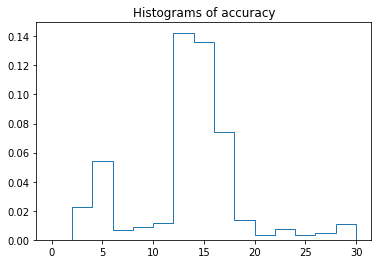

In [15]:
fig, ax = plt.subplots()

ax.set_title("Histograms of accuracy")

bins =  np.linspace(0, min_accuracy, 16)
for name, df in available_dfs.items():
   
    ax.hist(df.accuracy, bins=bins,density=True, histtype='step')


In [16]:
df.timestamp.tail(10)

380201   2020-03-26 17:52:06.400
380202   2020-03-26 17:53:08.662
380203   2020-03-26 17:54:32.424
380204   2020-03-26 17:56:58.793
380205   2020-03-26 17:59:32.488
380206   2020-03-26 18:00:07.660
380207   2020-03-26 18:02:10.350
380208   2020-03-26 18:03:08.659
380209   2020-03-26 18:07:47.766
380210   2020-03-26 18:10:59.737
Name: timestamp, dtype: datetime64[ns]

In [0]:
# use strftime because the weekofyear starts on Sunday
df["weekofyear"] = df.timestamp.dt.strftime('%W').astype(int)
df["year"] = df.timestamp.dt.year

In [18]:
df.head()

,timestamp,latitude,longitude,accuracy,weekofyear,year
16,2013-05-02 16:12:14.873,50.837178,4.415749,10,17,2013
60,2013-05-07 05:16:57.009,50.843692,4.417732,5,18,2013
61,2013-05-07 05:19:57.027,50.835368,4.414639,5,18,2013
62,2013-05-07 05:21:57.032,50.828381,4.407342,5,18,2013
63,2013-05-07 05:24:57.047,50.821195,4.407664,5,18,2013


In [19]:
# how many datapoints per year
df.groupby(["year"]).count()

,timestamp,latitude,longitude,accuracy,weekofyear
year,,,,,
2013,25,25,25,25,25
2018,1100,1100,1100,1100,1100
2019,259504,259504,259504,259504,259504
2020,68866,68866,68866,68866,68866


In [20]:
# we can also groupby two columns
df.groupby(["year", "weekofyear"]).count()

timestamp  latitude  longitude  accuracy
year weekofyear                                          
2013 17                  1         1          1         1
     18                 22        22         22        22
     20                  1         1          1         1
     21                  1         1          1         1
2018 42                 80        80         80        80
...                    ...       ...        ...       ...
2020 8                5190      5190       5190      5190
     9                4883      4883       4883      4883
     10               5016      5016       5016      5016
     11               5383      5383       5383      5383
     12               3541      3541       3541      3541

[82 rows x 4 columns]

In [0]:
# trick to generate the location history of many individuals
# from only a few

# we will make all the data correspond to the week starting

fake_start_week = pd.to_datetime('2020121', format='%Y%W%w')

many_df = {}
for name in available_dfs:
    
    df = available_dfs[name]
    df["weekofyear"] = df.timestamp.dt.strftime('%W').astype(int)
    df["year"] = df.timestamp.dt.year

    grouped_df = df.groupby(["year", "weekofyear"])
    for keys, group_df in grouped_df:
        year, weekofyear = keys
        
        # shift datetime so all the data start on fake_week_starts
        date_str = f"{year:04d}{weekofyear:02d}"
        week_date = pd.to_datetime(date_str + '1', format='%Y%W%w')
        shift = fake_start_week - week_date
        new_df =  group_df.copy()
        new_df["timestamp"] = group_df.timestamp + shift
        
        # create new dataframe (use timestamp as index)
        new_name =  f"{name}_{year}_{weekofyear}"
        del new_df["weekofyear"]
        del new_df["year"]
        many_df[new_name] = new_df.set_index("timestamp")

In [22]:
# we have now the data equivalent to several people during
# last week
len(many_df)

82

In [0]:
# it might be easier to use ordered lists
many_df_list = list(many_df.values())
many_df_names = list(many_df.keys())

In [36]:
import folium
import random
import matplotlib.colors as mcolors
import itertools

cycle_colors = itertools.cycle(mcolors.TABLEAU_COLORS.values())

coord_names = ["latitude", "longitude"]

location = (41.6523, -4.7245)

example_loc_hists = random.sample(many_df_list, 10)

m = folium.Map(location=location,
               zoom_start=1)

for example_df, color in zip(example_loc_hists,
                             cycle_colors):
    
    points = example_df[coord_names].values
    folium.PolyLine(points, color=color).add_to(m)
    
    print(example_df.index.min(), example_df.index.max())

m

2020-03-23 00:00:00.363000 2020-03-29 23:59:48.320000
2020-03-23 00:00:05.301000 2020-03-26 18:10:59.737000
2020-03-23 00:00:23.289000 2020-03-29 23:59:32.412000
2020-03-23 00:00:00.008000 2020-03-29 23:30:46.862000
2020-03-23 00:01:57.581000 2020-03-29 23:59:01.500000
2020-03-23 13:28:40.148000 2020-03-29 10:47:30.083000
2020-03-23 00:00:07.175000 2020-03-29 23:59:15.246000
2020-03-23 06:47:34.101000 2020-03-28 15:30:07.054000
2020-03-23 00:01:41.701000 2020-03-29 23:55:55.878000
2020-03-23 00:09:01.769000 2020-03-29 23:59:57.981000


In [25]:
df = example_loc_hists[0]
df.head()

,latitude,longitude,accuracy
timestamp,,,
2020-03-23 00:01:05.767,43.454262,-3.844269,12
2020-03-23 00:01:52.649,43.454258,-3.844256,13
2020-03-23 00:02:44.636,43.454279,-3.844234,14
2020-03-23 00:04:01.592,43.454258,-3.844256,13
2020-03-23 00:06:01.724,43.454258,-3.844256,13


In [26]:
df_resample = df.resample('1min').mean()
df_interp = df_resample.interpolate('time')
df_interp.head()

,latitude,longitude,accuracy
timestamp,,,
2020-03-23 00:01:00,43.454260,-3.844263,12.5
2020-03-23 00:02:00,43.454279,-3.844234,14.0
2020-03-23 00:03:00,43.454269,-3.844245,13.5
2020-03-23 00:04:00,43.454258,-3.844256,13.0
2020-03-23 00:05:00,43.454258,-3.844256,13.0


In [0]:
# we can apply the interpolation to all the dataframes
# to unify the treatment

# to keep the detailed data we are only going only to consider
# cases with more than 1000 row
min_n_rows = 1000

formated_df_dict = {}
for name, df in many_df.items():
    if len(df) > min_n_rows:
        resampled_df = df.resample('1min').mean()
        
        df_resample = df.resample('1min').mean()
        df_interp = df_resample.interpolate('time')
        
        formated_df_dict[name] = df_interp
    

In [28]:
formated_df_dict[name]

,latitude,longitude,accuracy
timestamp,,,
2020-03-23 00:00:00,43.454391,-3.844285,13.0
2020-03-23 00:01:00,43.454419,-3.844304,8.5
2020-03-23 00:02:00,43.454447,-3.844322,4.0
2020-03-23 00:03:00,43.454391,-3.844285,13.0
2020-03-23 00:04:00,43.454447,-3.844322,4.0
...,...,...,...
2020-03-26 18:06:00,43.454388,-3.844286,13.0
2020-03-26 18:07:00,43.454388,-3.844286,13.0
2020-03-26 18:08:00,43.454388,-3.844286,13.0


In [29]:
# create single single dataframe with index level per person
single_df = pd.concat(formated_df_dict, names=["person_id"])
single_df

latitude  ...   accuracy
person_id                            timestamp                       ...           
takeout-20200326T185219Z-001_2019_14 2020-03-23 19:04:00  40.495117  ...  10.000000
                                     2020-03-23 19:05:00  40.494187  ...   9.285714
                                     2020-03-23 19:06:00  40.493258  ...   8.571429
                                     2020-03-23 19:07:00  40.492329  ...   7.857143
                                     2020-03-23 19:08:00  40.491400  ...   7.142857
...                                                             ...  ...        ...
takeout-20200326T185219Z-001_2020_12 2020-03-26 18:06:00  43.454388  ...  13.000000
                                     2020-03-26 18:07:00  43.454388  ...  13.000000
                                     2020-03-26 18:08:00  43.454388  ...  13.000000
                                     2020-03-26 18:09:00  43.454388  ...  13.000000
                                     2020-03-26 18:10:00  43.454388  ...  13.000000

[507835 rows x 3 columns]

In [30]:
# this is a more useful grouping
time_single_df = single_df.swaplevel().sort_index()
time_single_df

latitude  ...  accuracy
timestamp           person_id                                        ...          
2020-03-23 00:00:00 takeout-20200326T185219Z-001_2019_17  43.454289  ...      16.0
                    takeout-20200326T185219Z-001_2019_18  43.454298  ...      16.0
                    takeout-20200326T185219Z-001_2019_20  43.454342  ...      13.0
                    takeout-20200326T185219Z-001_2019_22  53.356851  ...      16.0
                    takeout-20200326T185219Z-001_2019_23  43.454322  ...       3.0
...                                                             ...  ...       ...
2020-03-29 23:59:00 takeout-20200326T185219Z-001_2020_3   43.454262  ...      13.0
                    takeout-20200326T185219Z-001_2020_4   43.454258  ...      13.0
                    takeout-20200326T185219Z-001_2020_5   43.454394  ...      13.0
                    takeout-20200326T185219Z-001_2020_6   43.454403  ...      13.0
                    takeout-20200326T185219Z-001_2020_8   43.454397  ...      29.0

[507835 rows x 3 columns]

In [31]:
example_time = "2020-03-25 19:00:00"
example_time_df = time_single_df.loc[example_time, coord_names]
example_time_df

latitude   longitude
timestamp           person_id                                                  
2020-03-25 19:00:00 takeout-20200326T185219Z-001_2019_14  43.454259   -3.844257
                    takeout-20200326T185219Z-001_2019_15  40.426771   -3.666958
                    takeout-20200326T185219Z-001_2019_16  46.230043    6.053037
                    takeout-20200326T185219Z-001_2019_17  43.454335   -3.844407
                    takeout-20200326T185219Z-001_2019_18  43.454312   -3.844260
                    takeout-20200326T185219Z-001_2019_19  43.454340   -3.844260
                    takeout-20200326T185219Z-001_2019_20  43.454340   -3.844259
                    takeout-20200326T185219Z-001_2019_21  45.703763   13.720485
                    takeout-20200326T185219Z-001_2019_22  43.454307   -3.844257
                    takeout-20200326T185219Z-001_2019_23  46.229707    6.053809
                    takeout-20200326T185219Z-001_2019_24  43.454324   -3.844258
                    takeout-20200326T185219Z-001_2019_25  43.454316   -3.844258
                    takeout-20200326T185219Z-001_2019_26  43.454311   -3.844267
                    takeout-20200326T185219Z-001_2019_27  35.691225  139.713143
                    takeout-20200326T185219Z-001_2019_28  41.657587   -0.882329
                    takeout-20200326T185219Z-001_2019_29  43.454346   -3.844259
                    takeout-20200326T185219Z-001_2019_30  46.309928    6.076261
                    takeout-20200326T185219Z-001_2019_31  46.309946    6.076299
                    takeout-20200326T185219Z-001_2019_32  50.868442    4.399265
                    takeout-20200326T185219Z-001_2019_33  50.714505    4.573010
                    takeout-20200326T185219Z-001_2019_34  50.852758    4.416253
                    takeout-20200326T185219Z-001_2019_35  50.852794    4.416277
                    takeout-20200326T185219Z-001_2019_36  46.262137    6.039249
                    takeout-20200326T185219Z-001_2019_37  46.262154    6.039207
                    takeout-20200326T185219Z-001_2019_38  46.228415    6.072458
                    takeout-20200326T185219Z-001_2019_39  46.262154    6.039207
                    takeout-20200326T185219Z-001_2019_40  46.262155    6.039190
                    takeout-20200326T185219Z-001_2019_41  46.262157    6.039212
                    takeout-20200326T185219Z-001_2019_42  46.309918    6.076238
                    takeout-20200326T185219Z-001_2019_43  50.739304    5.119067
                    takeout-20200326T185219Z-001_2019_44  46.268729    6.101959
                    takeout-20200326T185219Z-001_2019_45  46.267990    6.099224
                    takeout-20200326T185219Z-001_2019_46  46.262158    6.039205
                    takeout-20200326T185219Z-001_2019_47  46.268728    6.101959
                    takeout-20200326T185219Z-001_2019_48  46.262118    6.039097
                    takeout-20200326T185219Z-001_2019_49  43.556743    1.429687
                    takeout-20200326T185219Z-001_2019_50  50.852748    4.416369
                    takeout-20200326T185219Z-001_2019_51  50.852788    4.416375
                    takeout-20200326T185219Z-001_2020_0   50.852722    4.416142
                    takeout-20200326T185219Z-001_2020_1   43.454258   -3.844267
                    takeout-20200326T185219Z-001_2020_10  46.230560    6.053839
                    takeout-20200326T185219Z-001_2020_11  43.454375   -3.844288
                    takeout-20200326T185219Z-001_2020_12  43.454387   -3.844283
                    takeout-20200326T185219Z-001_2020_2   43.454311   -3.844277
                    takeout-20200326T185219Z-001_2020_3   43.454249   -3.844262
                    takeout-20200326T185219Z-001_2020_4   43.454278   -3.844254
                    takeout-20200326T185219Z-001_2020_5   43.455855   -3.840921
                    takeout-20200326T185219Z-001_2020_6   43.463879   -3.828757
                    takeout-20200326T185219Z-001_2020_7   4

In [37]:
!pip install haversine
from haversine import haversine_vector, Unit

coord_arr = example_time_df.values
dist_matrix = haversine_vector(coord_arr[:,:,np.newaxis], coord_arr, unit=Unit.METERS)
upper_diag_filter = np.triu(np.ones_like(dist_matrix, dtype=np.bool), k=1)
closer_than_matrix = dist_matrix < 60.0
print("possible pairs: ", np.sum(upper_diag_filter))
closer_pair_mask = upper_diag_filter & closer_than_matrix
print("closer pairs: ", np.sum(closer_pair_mask))

possible pairs:  1275
closer pairs:  171


In [38]:
edges = np.array(np.where(closer_pair_mask)).T

edges

array([[ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  8],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 15],
       [ 0, 39],
       [ 0, 41],
       [ 0, 42],
       [ 0, 43],
       [ 0, 44],
       [ 0, 45],
       [ 0, 50],
       [ 3,  4],
       [ 3,  5],
       [ 3,  6],
       [ 3,  8],
       [ 3, 10],
       [ 3, 11],
       [ 3, 12],
       [ 3, 15],
       [ 3, 39],
       [ 3, 41],
       [ 3, 42],
       [ 3, 43],
       [ 3, 44],
       [ 3, 45],
       [ 3, 50],
       [ 4,  5],
       [ 4,  6],
       [ 4,  8],
       [ 4, 10],
       [ 4, 11],
       [ 4, 12],
       [ 4, 15],
       [ 4, 39],
       [ 4, 41],
       [ 4, 42],
       [ 4, 43],
       [ 4, 44],
       [ 4, 45],
       [ 4, 50],
       [ 5,  6],
       [ 5,  8],
       [ 5, 10],
       [ 5, 11],
       [ 5, 12],
       [ 5, 15],
       [ 5, 39],
       [ 5, 41],
       [ 5, 42],
       [ 5, 43],
       [ 5, 44],
       [ 5, 45],
       [ 5, 50],
       [ 6,  8

In [39]:
!pip install networkx

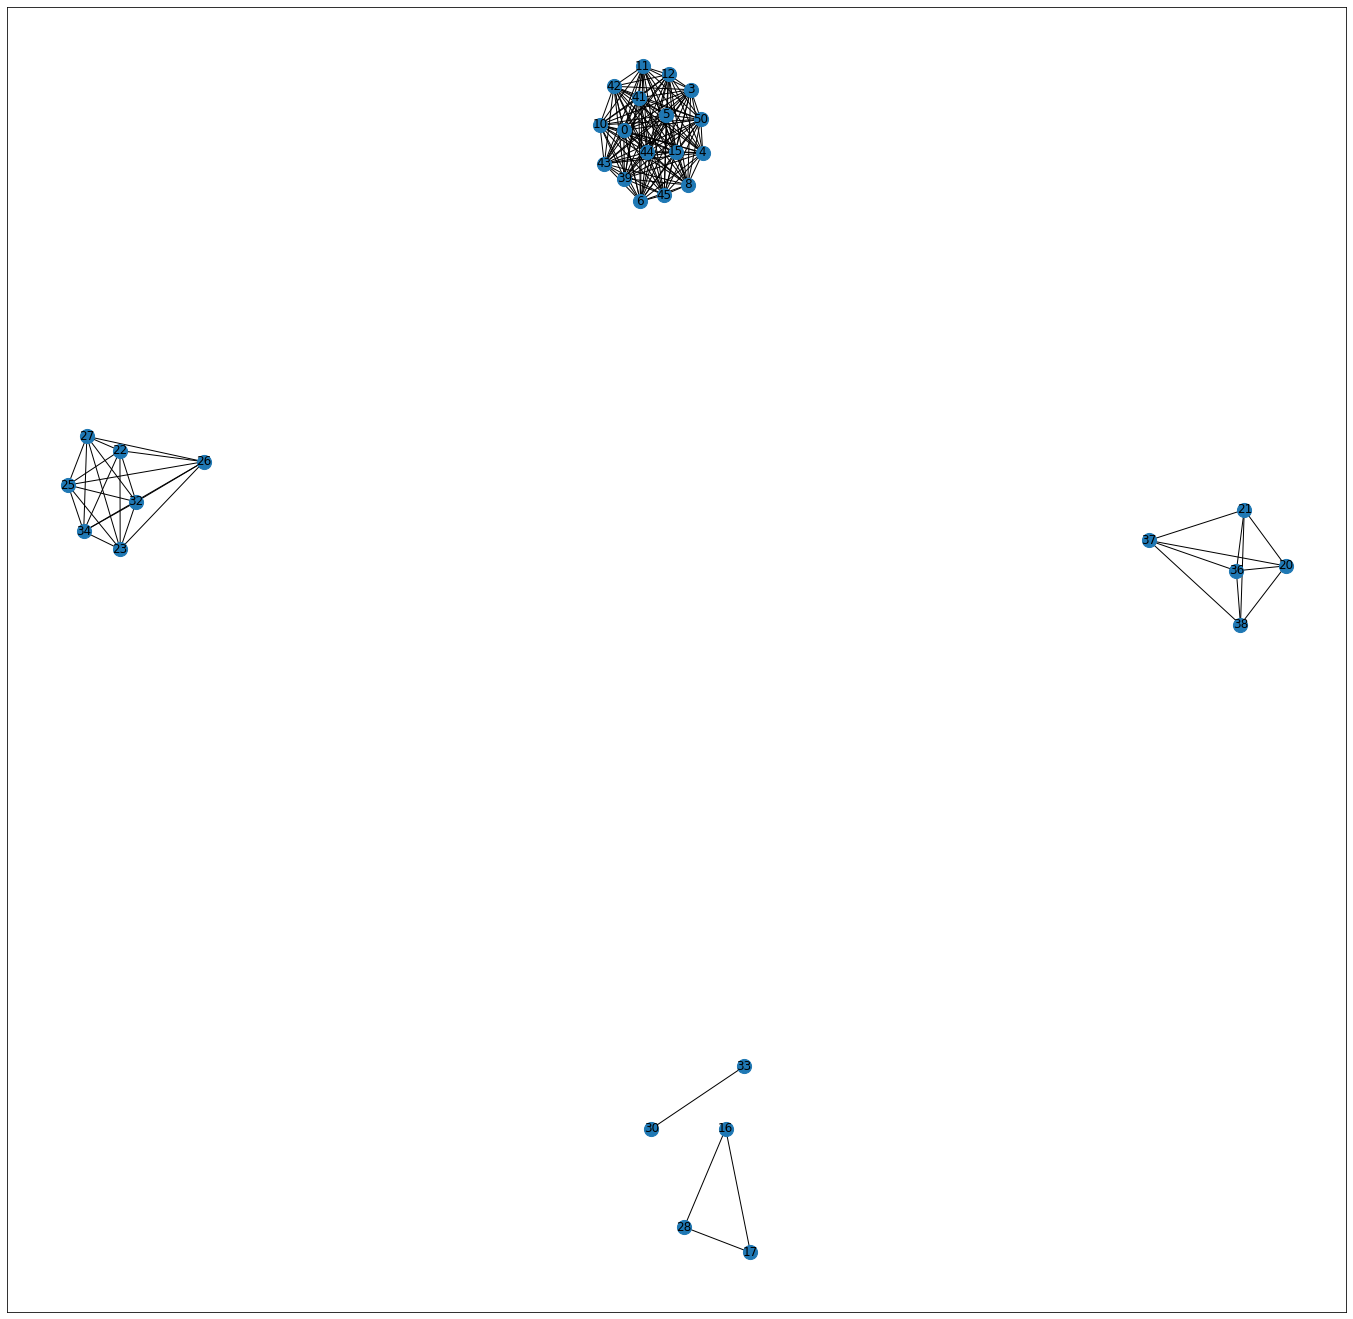

In [40]:
import networkx as nx

fig, ax = plt.subplots(figsize=(24,24))
gr = nx.Graph()
gr.add_edges_from(edges)
pos=nx.spring_layout(gr, k=0.3)
nx.draw_networkx(gr, pos=pos, node_size=200,ax=ax)

In [41]:
from folium.plugins import HeatMap

# carculate the centroid
centroid_coord = (coord_arr[edges[:,0]] + coord_arr[edges[:,1]])/2.

m = folium.Map(location=location,
               zoom_start=6) 

HeatMap(data=centroid_coord.tolist()).add_to(m)
m

In [47]:
# now suppose that someone has tested positive on the 29th
# find who else could he/she have infected last week by being in contact
# and where it could have happened

infected_person = random.sample(list(time_single_df.index.get_level_values("person_id").unique()),1)
print(infected_person)

['takeout-20200326T185219Z-001_2019_34']


In [0]:
time_single_df.loc[(slice(None), infected_person),:] #Where the infected person has been
other_people = list(set(time_single_df.index.get_level_values("person_id")) - set(infected_person))
other_locations = time_single_df.loc[(slice(None), other_people), :]

In [62]:
for person_name, non_infected_df in other_locations.groupby("person_id"):
  print(person_name)

takeout-20200326T185219Z-001_2019_14
takeout-20200326T185219Z-001_2019_15
takeout-20200326T185219Z-001_2019_16
takeout-20200326T185219Z-001_2019_17
takeout-20200326T185219Z-001_2019_18
takeout-20200326T185219Z-001_2019_19
takeout-20200326T185219Z-001_2019_20
takeout-20200326T185219Z-001_2019_21
takeout-20200326T185219Z-001_2019_22
takeout-20200326T185219Z-001_2019_23
takeout-20200326T185219Z-001_2019_24
takeout-20200326T185219Z-001_2019_25
takeout-20200326T185219Z-001_2019_26
takeout-20200326T185219Z-001_2019_27
takeout-20200326T185219Z-001_2019_28
takeout-20200326T185219Z-001_2019_29
takeout-20200326T185219Z-001_2019_30
takeout-20200326T185219Z-001_2019_31
takeout-20200326T185219Z-001_2019_32
takeout-20200326T185219Z-001_2019_33
takeout-20200326T185219Z-001_2019_35
takeout-20200326T185219Z-001_2019_36
takeout-20200326T185219Z-001_2019_37
takeout-20200326T185219Z-001_2019_38
takeout-20200326T185219Z-001_2019_39
takeout-20200326T185219Z-001_2019_40
takeout-20200326T185219Z-001_2019_41
t